In [1]:
import sys
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import pandas as pd
import numpy as np
import os

import joblib
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/NonPromoterSequence.txt', sep = '>', )
df.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
df.reset_index(inplace = True)
df.drop(['EP 1 (+) mt:CoI_1; range -400 to -100.', 'index'], axis = 1, inplace=True) #data cleaning after error found
df.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
df['label'] = 0
display(df)
display(df.shape)

,sequence,label
0,TAATTACATTATTTTTTTATTTACGAATTTGTTATTCCGCTTTTAT...,0
1,ATTTTTACAAGAACAAGACATTTAACTTTAACTTTATCTTTAGCTT...,0
2,AGAGATAGGTGGGTCTGTAACACTCGAATCAAAAACAATATTAAGA...,0
3,TATGTATATAGAGATAGGCGTTGCCAATAACTTTTGCGTTTTTTGC...,0
4,AGAAATAATAGCTAGAGCAAAAAACAGCTTAGAACGGCTGATGCTC...,0
...,...,...
11295,TGGTAAAAAATTGTACACCTAACTAGTGCCTTCATGTATACCACCA...,0
11296,AGTGCAACTGGAGCCGTGCCGTGACCCACAGAGATCGCCCACTCGA...,0
11297,GCATGGATTTCATATTATCTTAATCGACTTGCTTTTATAAAATAGG...,0
11298,GTGACCAGGTTTTGCTCTAATGCGAAGTACGGATTGGGTAGAGATA...,0


(11300, 2)

In [5]:
df2 = pd.read_csv('/content/gdrive/MyDrive/PromoterSequence.txt', sep = '>', )
df2.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
df2.reset_index(inplace = True)
df2.drop(['EP 1 (+) mt:CoI_1; range -100 to 200.', 'index'], axis = 1, inplace=True)
df2.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
df2['label'] = 1

display(df2)
display(df2.shape)


,sequence,label
0,TTAATTTGTCCTTATTTGATTAAGAAGAATAAATCTTATATATAGA...,1
1,ATAGCTCAAATTGCTTTATTAGTATTAGAATCAGCTGTAGCTATAA...,1
2,AAGCTTCCCTTTAATGTGCTCCTTGTGAATACAGCATTACAATGCC...,1
3,TATGTAGAATCTGTACAAGTATCTGTGTTTGGACAATGGCATGTGT...,1
4,ACATATTACTGCATACAGGTCTCAAATTATAAAATGACACTCGTGG...,1
...,...,...
11295,CGACAAAGTTTGATCCATGTGCATTCTTGGCGCCTTATCGATAGCT...,1
11296,CATATCTACATCTCGCTTGCTCCTTCCCTTTCGCTGCGTGTGTGTG...,1
11297,ATACCGCGGAAGCGCAAAAGTACCAGAATTTCCCTGGTATCGCGCT...,1
11298,ATTATTCCGAATTCTTTTATCAGATTTAAATATGGGAAACACTTTA...,1


(11300, 2)

In [6]:
df = pd.concat([df, df2], axis = 0 )
df.shape


(22600, 2)

In [7]:
for seq in df['sequence']:
    if 'N' in seq:
        display(df.loc[df['sequence'] == seq])

,sequence,label
1822,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGAATTC...,0


In [8]:
df.drop([1822], inplace = True)

In [9]:
for seq in df['sequence']:
    if 'N' in seq:
        display(df.loc[df['sequence'] == seq])

In [10]:
sequence = list(df.loc[:, 'sequence'])
encoded_list = []


In [11]:
def encode_seq(s):
  Encode = {'A': 0,'T': 1,'C': 2,'G': 3}
  ret = []
  for i in range(len(s) - 2):
    encode_vec = [0 for j in range(7)]
    encode_index = 0
    encode_index += Encode[s[i]]
    encode_index += Encode[s[i+1]]*4
    encode_index += Encode[s[i+2]]*16
    for j in range(7):
      if encode_index % 2 == 1:
        encode_vec[j] = 1
      encode_index = encode_index / 2
    ret.append(encode_vec)
  return ret

for i in sequence:
  x = encode_seq(i)
  encoded_list.append(x)


# def encode_seq(s):
#     Encode = {'A':[1,0,0,0],'T':[0,1,0,0],'C':[0,0,1,0],'G':[0,0,0,1]}
#     return [Encode[x] for x in s]

# for i in sequence:
#     x = encode_seq(i)
#     encoded_list.append(x)

X = np.array(encoded_list)
X.shape



(22598, 299, 7)

In [12]:
y = df['label']
y.shape
X.shape

(22598, 299, 7)

In [13]:
X_train, X_not_train, y_train, y_not_train = train_test_split(X, y, test_size = 0.1, random_state = 42, stratify = y)
y_train = utils.to_categorical(y_train)

X_val, X_test, y_val, y_test = train_test_split(X_not_train, y_not_train, random_state = 42, stratify = y_not_train, test_size=0.5)

y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

X_train = tf.cast(X_train, dtype='float32')
X_val = tf.cast(X_val, dtype='float32')
X_test = tf.cast(X_test, dtype='float32')

with tensorflow.device('/device:GPU:0'):
  gru_model = Sequential()

  gru_model.add(Bidirectional(GRU(128, activation = 'relu')))
  gru_model.add(Dropout(0.2))
  gru_model.add(Dense(128, activation = 'relu'))
  gru_model.add(Dense(64, activation = 'relu'))
  gru_model.add(Dense(64, activation = 'relu'))
  gru_model.add(Dense(16, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
  gru_model.add(Dense(2, activation = 'sigmoid'))

  gru_model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience=8, 
                                            restore_best_weights=True )
  history = gru_model.fit(X_train, y_train, batch_size = 128, validation_data=(X_val, y_val), 
                          epochs=40)

Epoch 1/40
159/159 [==============================] - 176s 1s/step - loss: 0.8246 - accuracy: 0.5379 - val_loss: 0.7260 - val_accuracy: 0.5823
Epoch 2/40
159/159 [==============================] - 173s 1s/step - loss: 0.7251 - accuracy: 0.5588 - val_loss: 0.7046 - val_accuracy: 0.4956
Epoch 3/40
159/159 [==============================] - 168s 1s/step - loss: 0.7021 - accuracy: 0.5075 - val_loss: 0.6669 - val_accuracy: 0.6425
Epoch 4/40
159/159 [==============================] - 169s 1s/step - loss: 0.6945 - accuracy: 0.5269 - val_loss: 0.6993 - val_accuracy: 0.5000
Epoch 5/40
159/159 [==============================] - 168s 1s/step - loss: 0.6984 - accuracy: 0.5038 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 6/40
159/159 [==============================] - 168s 1s/step - loss: 0.6970 - accuracy: 0.5080 - val_loss: 0.6963 - val_accuracy: 0.5000
Epoch 7/40
159/159 [==============================] - 168s 1s/step - loss: 0.6959 - accuracy: 0.5115 - val_loss: 0.6956 - val_accuracy: 0.5000

In [14]:
pred = gru_model.predict

In [15]:
preds = gru_model.predict(X_test)


36/36 [==============================] - 3s 88ms/step


In [16]:
# get accuracy
# positive: is promoter
tn = 0
fn = 0
fp = 0
tp = 0

for i in range(len(preds)):
  if preds[i][0] >= preds[i][1]: # non-promoter
    preds[i][0] = 1
    preds[i][1] = 0
  else:                          # promoter
    preds[i][0] = 0
    preds[i][1] = 1

for i in range(len(preds)):
  if(preds[i][0] > preds[i][1]): # non-promoter
    if y_test[i][0] == 1:
      tn += 1
    else:
      fn += 1
  else:                          # promoter
    if y_test[i][1] == 1:
      tp += 1
    else:
      fp += 1

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fn + fp + tn)
print(precision, recall, accuracy)
print(tp, fn, fp, tn)

0.7164179104477612 0.7646017699115044 0.7309734513274336
432 133 171 394


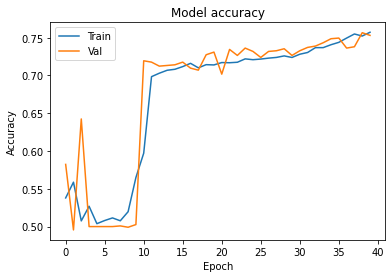

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('window GRU accuracy')

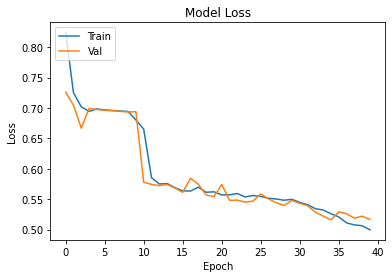

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('window GRU loss')

In [19]:
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              105216    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                        